# Home 4: Build a CNN for image recognition.

### Name: [Marco Vlajnic]


## 0. You will do the following:

1. Read, complete, and run the code.

2. **Make substantial improvements** to maximize the accurcy.
    
3. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain the code and the output after execution.
    
    * Missing **the output after execution** will not be graded.
    
4. Upload this .HTML file to your Google Drive, Dropbox, or Github repo. (If you submit the file to Google Drive or Dropbox, you must make the file "open-access". The delay caused by "deny of access" may result in late penalty.)

4. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2020S/blob/master/homework/HM4/HM4.html


## Requirements:

1. You can use whatever CNN architecture, including VGG, Inception, and ResNet. However, you must build the networks layer by layer. You must NOT import the archetectures from ```keras.applications```.

2. Make sure ```BatchNormalization``` is between a ```Conv```/```Dense``` layer and an ```activation``` layer.

3. If you want to regularize a ```Conv```/```Dense``` layer, you should place a ```Dropout``` layer **before** the ```Conv```/```Dense``` layer.

4. An accuracy above 70% is considered reasonable. An accuracy above 80% is considered good. Without data augmentation, achieving 80% accuracy is difficult.


## Google Colab

- If you do not have GPU, the training of a CNN can be slow. Google Colab is a good option.

- Keep in mind that you must download it as an IPYNB file and then use IPython Notebook to convert it to HTML.

- Also keep in mind that the IPYNB and HTML files must contain the outputs. (Otherwise, the instructor will not be able to know the correctness and performance.) Do the followings to keep the outputs.

- In Colab, go to ```Runtime``` --> ```Change runtime type``` --> Do NOT check ```Omit code cell output when saving this notebook```. In this way, the downloaded IPYNB file contains the outputs.

## 1. Data preparation

### 1.1. Load data


In [1]:
from keras.datasets import cifar10
import numpy

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('shape of x_train: ' + str(x_train.shape))
print('shape of y_train: ' + str(y_train.shape))
print('shape of x_test: ' + str(x_test.shape))
print('shape of y_test: ' + str(y_test.shape))
print('number of classes: ' + str(numpy.max(y_train) - numpy.min(y_train) + 1))

shape of x_train: (50000, 32, 32, 3)
shape of y_train: (50000, 1)
shape of x_test: (10000, 32, 32, 3)
shape of y_test: (10000, 1)
number of classes: 10


### 1.2. One-hot encode the labels

In the input, a label is a scalar in $\{0, 1, \cdots , 9\}$. One-hot encode transform such a scalar to a $10$-dim vector. E.g., a scalar ```y_train[j]=3``` is transformed to the vector ```y_train_vec[j]=[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]```.

1. Define a function ```to_one_hot``` that transforms an $n\times 1$ array to a $n\times 10$ matrix.

2. Apply the function to ```y_train``` and ```y_test```.

In [2]:
def to_one_hot(y, num_class=10):
    
    result = numpy.zeros(shape=(y.shape[0],num_class))
    for i in range(y.shape[0]):
        result[i][y[i]]=1 
    return result

y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)

print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))

print(y_train[0])
print(y_train_vec[0])

Shape of y_train_vec: (50000, 10)
Shape of y_test_vec: (10000, 10)
[6]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


#### Remark: the outputs should be
* Shape of y_train_vec: (50000, 10)
* Shape of y_test_vec: (10000, 10)
* [6]
* [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]

### 1.3. Randomly partition the training set to training and validation sets

Randomly partition the 50K training samples to 2 sets:
* a training set containing 40K samples
* a validation set containing 10K samples


In [3]:
rand_indices = numpy.random.permutation(50000)
train_indices = rand_indices[0:40000]
valid_indices = rand_indices[40000:50000]

x_val = x_train[valid_indices, :]
y_val = y_train_vec[valid_indices, :]

x_tr = x_train[train_indices, :]
y_tr = y_train_vec[train_indices, :]

print('Shape of x_tr: ' + str(x_tr.shape))
print('Shape of y_tr: ' + str(y_tr.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))

Shape of x_tr: (40000, 32, 32, 3)
Shape of y_tr: (40000, 10)
Shape of x_val: (10000, 32, 32, 3)
Shape of y_val: (10000, 10)


## 2. Build a CNN and tune its hyper-parameters

1. Build a convolutional neural network model
2. Use the validation data to tune the hyper-parameters (e.g., network structure, and optimization algorithm)
    * Do NOT use test data for hyper-parameter tuning!!!
3. Try to achieve a validation accuracy as high as possible.

### Remark: 

The following CNN is just an example. You are supposed to make **substantial improvements** such as:
* Add more layers.
* Use regularizations, e.g., dropout.
* Use batch normalization.

In [4]:
from keras.layers import *
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator

# Image generator for training
def make_generator(X):
    gen = ImageDataGenerator(
            rotation_range=40,
            zoom_range=0.2,
            shear_range=0.2,
            width_shift_range=0.2,
            height_shift_range=0.2,
            fill_mode='nearest',
            horizontal_flip=True,
    )
    gen.fit(X)
    return gen

# Create a generator for the training data
gen = make_generator(x_tr)

def add_skip_connection(model, input_shape=None):
    input_shape = input_shape or model.output_shape[1:]
    
    # Input to the residual block
    x = Input(shape=input_shape)
    
    trace = Sequential()
    
    trace.add(BatchNormalization(input_shape=input_shape))
    trace.add(Activation('relu'))
    trace.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
    
    trace.add(BatchNormalization())
    trace.add(Activation('relu'))
    trace.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
    
    y = trace(x)
    
    residual_block = Model(x, Add()([x, y]))
    
    model.add(residual_block)
    

def make_model():
    model = Sequential()
    

    model.add(Conv2D(64, (7, 7), padding='same', input_shape=(32, 32, 3)))
    
    # We will reduce the dimensionality 3 times
    for _ in range(3):
        # At each level, we will have three tiers of residual blocks
        for _ in range(2):
            add_skip_connection(model)
            
        # We will also reduce to half size
        model.add(MaxPooling2D((2, 2)))
    
    
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Dropout(0.5))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Dropout(0.5))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Dropout(0.5))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    

    model.add(Flatten())

    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))

    model.add(Dense(10, activation='softmax'))
    
    return model

model = make_model()

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        9472      
_________________________________________________________________
functional_1 (Functional)    (None, 32, 32, 64)        74368     
_________________________________________________________________
functional_3 (Functional)    (None, 32, 32, 64)        74368     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
functional_5 (Functional)    (None, 16, 16, 64)        74368     
_________________________________________________________________
functional_7 (Functional)    (None, 16, 16, 64)        74368     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0

In [5]:
from keras import optimizers

learning_rate = 2E-4 # to be tuned!


model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=learning_rate),
              metrics=['acc'])

In [18]:
history = model.fit_generator(gen.flow(x_tr, y_tr, batch_size=32),
                              steps_per_epoch=len(x_tr) // 32, epochs=10,
                              validation_data=(x_val, y_val))

Epoch 1/10
1250/1250 [==============================] - 1348s 1s/step - loss: 1.0059 - acc: 0.6592 - val_loss: 0.9592 - val_acc: 0.6559
Epoch 2/10
1250/1250 [==============================] - 1320s 1s/step - loss: 0.9955 - acc: 0.6640 - val_loss: 0.7886 - val_acc: 0.7359
Epoch 3/10
1250/1250 [==============================] - 1377s 1s/step - loss: 0.9911 - acc: 0.6647 - val_loss: 0.8570 - val_acc: 0.7118
Epoch 4/10
1250/1250 [==============================] - 1345s 1s/step - loss: 0.9707 - acc: 0.6722 - val_loss: 0.9627 - val_acc: 0.6581
Epoch 5/10
1250/1250 [==============================] - 1421s 1s/step - loss: 0.9708 - acc: 0.6735 - val_loss: 0.8389 - val_acc: 0.7206
Epoch 6/10
1250/1250 [==============================] - 1299s 1s/step - loss: 0.9599 - acc: 0.6746 - val_loss: 0.8192 - val_acc: 0.7302
Epoch 7/10
1250/1250 [==============================] - 1284s 1s/step - loss: 0.9598 - acc: 0.6775 - val_loss: 0.9184 - val_acc: 0.6793
Epoch 8/10
1250/1250 [==========================

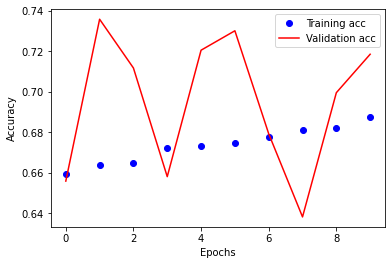

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 3. Train (again) and evaluate the model

- To this end, you have found the "best" hyper-parameters. 
- Now, fix the hyper-parameters and train the network on the entire training set (all the 50K training samples)
- Evaluate your model on the test set.

### 3.1. Train the model on the entire training set

Why? Previously, you used 40K samples for training; you wasted 10K samples for the sake of hyper-parameter tuning. Now you already know the hyper-parameters, so why not using all the 50K samples for training?

In [6]:
history = model.fit(x_train, y_train_vec, batch_size=32, epochs=10)

Epoch 1/10
1563/1563 [==============================] - 1661s 1s/step - loss: 2.1569 - acc: 0.1743
Epoch 2/10
1563/1563 [==============================] - 1530s 979ms/step - loss: 1.7917 - acc: 0.2742
Epoch 3/10
1563/1563 [==============================] - 1491s 954ms/step - loss: 1.6206 - acc: 0.3483
Epoch 4/10
1563/1563 [==============================] - 1501s 960ms/step - loss: 1.4878 - acc: 0.4112
Epoch 5/10
1563/1563 [==============================] - 1491s 954ms/step - loss: 1.3903 - acc: 0.4633
Epoch 6/10
1563/1563 [==============================] - 1500s 959ms/step - loss: 1.3086 - acc: 0.5071
Epoch 7/10
1563/1563 [==============================] - 1488s 952ms/step - loss: 1.2300 - acc: 0.5485
Epoch 8/10
1563/1563 [==============================] - 1490s 953ms/step - loss: 1.1593 - acc: 0.5862
Epoch 9/10
1563/1563 [==============================] - 1498s 958ms/step - loss: 1.0970 - acc: 0.6142
Epoch 10/10
1563/1563 [==============================] - 1568s 1s/step - loss: 1.0290

### 3.2. Evaluate the model on the test set

Do NOT used the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.

In [7]:
loss_and_acc = model.evaluate(x_test, y_test_vec)
print('loss = ' + str(loss_and_acc[0]))
print('accuracy = ' + str(loss_and_acc[1]))

313/313 [==============================] - 60s 191ms/step - loss: 1.1299 - acc: 0.5890
loss = 1.1298677921295166
accuracy = 0.5889999866485596
